# Pair Trading Backtest

**Objective**: In this notebook, we backtest a pair trading strategy using HSCEI and XIN9I. We apply a Kalman filter to the log of their closing prices to estimate the spread. Trading signals are based on the 20-day rolling z-score of the spread:

Short the spread when z-score > 2
Long the spread when z-score < -2
Positions are closed when |z-score| < 1.
We hold at most a position at a time. Each trade uses a fixed notional amount, and weights remain unchanged until the position is unwound.

We will evaluate performance using metrics such as cumulative PnL, Sharpe ratio, and drawdown, and visualize signals and PnL.

**Enhancement**: We will also attempt to improve the strategy by incorporating a regime shift detection filter. When a regime shift is detected, we will pause trading activity—meaning we will not open new positions or unwind existing ones until the market stabilizes and a new valid signal emerges. This aims to reduce risk during periods of structural change.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import vectorbt as vbt
from pair_trading_signal import SignalGeneration
from mmd_regime_shift_detector import apply_position_filter, RegimeShiftDetector
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', '{:_.4f}'.format)


def get_vbt_signals(signal_df):
    """
    Rules:
      - 0->1: enter long
      - 0->-1: enter short
      - 1->0: exit long
      - -1->0: exit short
      - 1->-1 or -1->1: exit then immediately enter opposite direction (same bar)
      - If signal stays at 1/-1: keep holding
      - If signal stays at 0: do nothing
    """
    
    # Previous signal (assume 0 before the first bar)
    prev = signal_df.shift(1).fillna(0).astype(int)

    # Entry/Exit logic per rules
    long_entries  = ((prev == 0) & (signal_df == 1)) | ((prev == -1) & (signal_df == 1))
    short_entries = ((prev == 0) & (signal_df == -1)) | ((prev == 1) & (signal_df == -1))

    long_exits  = ((prev == 1) & (signal_df == 0)) | ((prev == 1) & (signal_df == -1))
    short_exits = ((prev == -1) & (signal_df == 0)) | ((prev == -1) & (signal_df == 1))

    long_entries  = long_entries.astype(bool)
    short_entries = short_entries.astype(bool)
    long_exits    = long_exits.astype(bool)
    short_exits   = short_exits.astype(bool)
    
    return long_entries, short_entries, long_exits, short_exits
    

def get_vbt_size(weight_df, price_df, fx_df, signal_df, fixed_amount=10_000):
    # Convert monetary capital to shares at the entry price
    fx_df = fx_df.reindex(weight_df.index)
    trade_capital  = fixed_amount * weight_df / fx_df.shift(1)
    size_in_shares = trade_capital / price_df.clip(lower=np.finfo(float).eps)
    
    long_entries, short_entries, _, _ = get_vbt_signals(signal_df)

    # Single `size` used for both long and short entries
    size = size_in_shares.where(long_entries | short_entries, other=0.0)
    
    return size
    

def preprocessing_data(price_df, signal_df, weight_df, fx_df):
    # Validate signal domain
    if not (((signal_df == 1) | (signal_df == 0) | (signal_df == -1)).all().all()):
        raise ValueError("`signal` must only contain -1, 0, or 1.")
    
    fx_df = fx_df.ffill()
    # Align index (inner intersection)
    common_index = (
        price_df.index
        .intersection(signal_df.index)
        .intersection(weight_df.index)
        .intersection(fx_df.index)
    )
    price_df  = price_df.loc[common_index]
    signal_df = signal_df.loc[common_index]
    weight_df = weight_df.loc[common_index]
    fx_df = fx_df.loc[common_index]
    
    # Rename columns 
    signal_df.columns = price_df.columns
    weight_df = weight_df.div(weight_df.sum(axis=1), axis=0)
    weight_df.columns = price_df.columns
    
    # Drop rows containing NaNs across any of the three to avoid partial computation
    valid_mask = (~price_df.isna()) & (~signal_df.isna()) & (~weight_df.isna())
    # Keep only rows where all assets are valid at the timestamp
    all_valid = valid_mask.all(axis=1)
    price_df  = price_df.loc[all_valid]
    signal_df = signal_df.loc[all_valid]
    weight_df = weight_df.loc[all_valid]
    fx_df = fx_df.loc[all_valid]
    
    return price_df, signal_df, weight_df, fx_df


In [2]:
def backtest_basket_signal_weight(
    price_df: pd.DataFrame,
    signal_df: pd.DataFrame,
    weight_df: pd.DataFrame,
    fx_df: pd.DataFrame, 
    fixed_amount: float,
    init_cash: float = 0, #1_000_000.0,
    fees: float | pd.Series | pd.DataFrame = 0.0,
    slippage: float | pd.Series | pd.DataFrame = 0.0,
    freq: str | None = None,
    cash_sharing: bool = True,
):
    """
    Basket backtest for {−1,0,1} signal with per-asset weights.

    Parameters
    ----------
    price_df : pd.DataFrame
        Close prices (columns = assets).
    signal_df : pd.DataFrame
        Signal in {−1, 0, 1} (columns aligned to `price`).
    weight_df : pd.DataFrame
        Weight per asset/time. Entry capital = fixed_amount * weight.
    fx_df: pd.DataFrame
        fx prices (columns = assets).
    fixed_amount : float
        Base monetary amount deployed per entry (per asset). Actual = fixed_amount * weight.
    init_cash : float
        Initial cash. If cash_sharing=True, shared across assets; else per asset.
    fees : float or Series/DataFrame
        Proportional fee per trade (e.g., 0.001 = 10 bps).
    slippage : float or Series/DataFrame
        Proportional slippage (e.g., 0.0005 = 5 bps).
    freq : str or None
        Frequency string (e.g., 'D') for stats.
    cash_sharing : bool
        Whether to share cash across assets.

    Returns
    -------
    vbt.Portfolio
        VectorBT portfolio object.
    """
    price_df, signal_df, weight_df, fx_df = preprocessing_data(price_df, signal_df, weight_df, fx_df)
    long_entries, short_entries, long_exits, short_exits = get_vbt_signals(signal_df)
    size = get_vbt_size(weight_df, price_df, fx_df, signal_df, fixed_amount=fixed_amount)
    size_type = 'amount'
    
    # Build portfolio
    pf = vbt.Portfolio.from_signals(
        close=price_df/fx_df,
        entries=long_entries,
        exits=long_exits,
        short_entries=short_entries,
        short_exits=short_exits,
        size=size,
        #size_type=size_type,
        fees=fees,
        slippage=slippage,
        init_cash=init_cash,
        cash_sharing=cash_sharing,
        freq=freq,
    )
    
    return pf

In [3]:
fx_dict = {
    'HSCEI': 'HKD',
    'XIN9I': 'USD',
}

# Kalman filter parameters
params={
    'observation_covariance': 2,
    'transition_covariance': [[0.0001, 0], [0, 0.0001]],
}

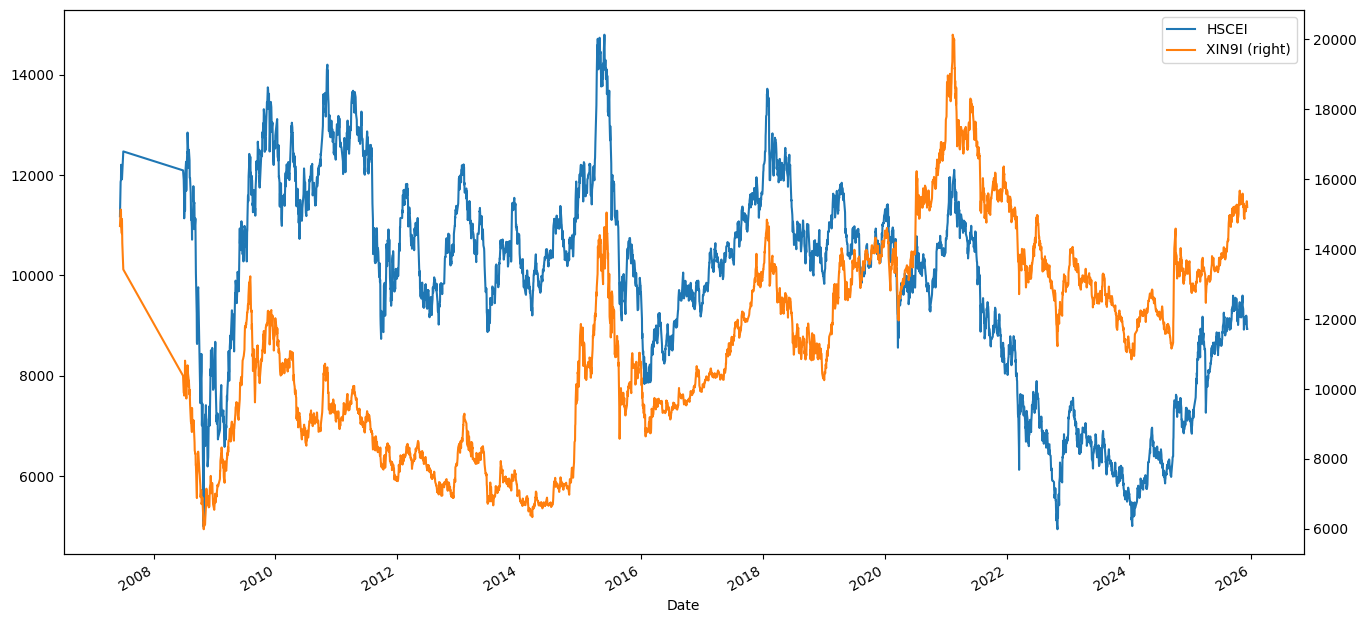

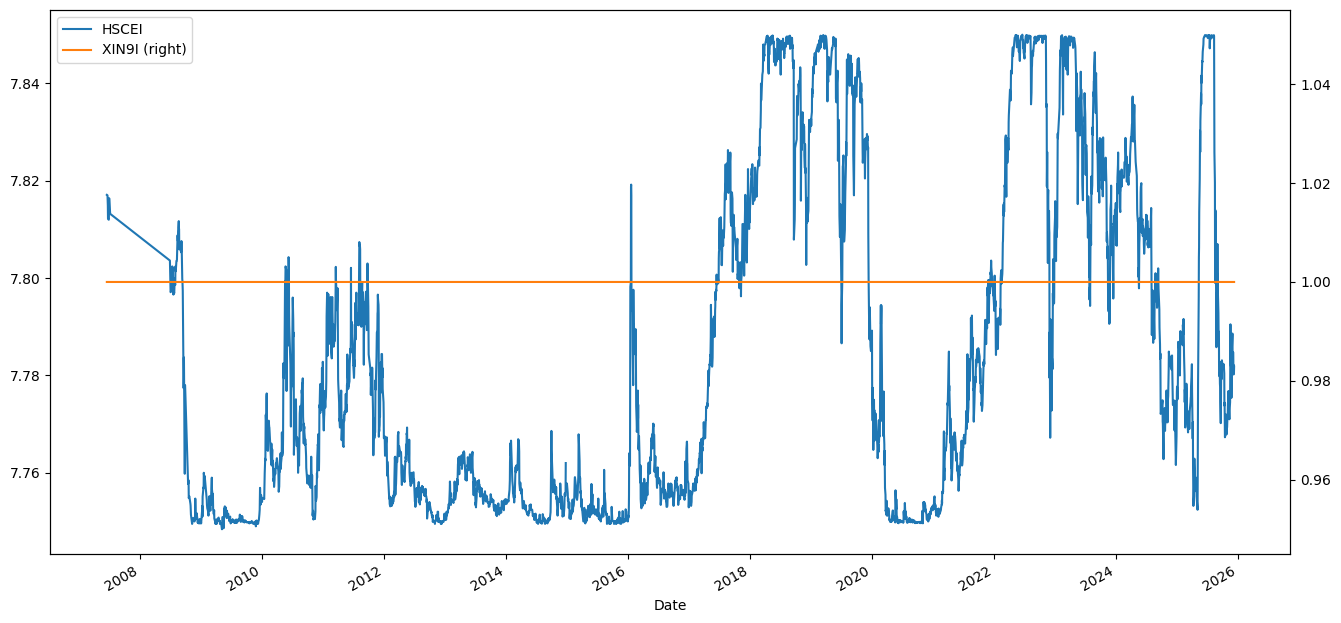

In [4]:
ticker1, ticker2 = 'HSCEI', 'XIN9I'

# Index data source: Google Finance
price_df = pd.read_csv('data/indices_data.csv', index_col=0, parse_dates=True).dropna()
_ = price_df.plot(secondary_y=ticker2)

# Foreign exchange (FX) data source: Alpha Vantage
fx_df = pd.read_csv('data/fx_data.csv', index_col=0, parse_dates=True)
fx_df.columns = [c[-3:] for c in fx_df.columns]    
fx_df = pd.DataFrame({asset: fx_df[fx_dict[asset]] for asset in price_df.columns})
fx_df = fx_df.reindex(price_df.index)
_ = fx_df.plot(secondary_y=ticker2)

,HSCEI,XIN9I
Date,,
2007-06-14,11_180.9200,14_661.1500
2007-06-18,11_866.7100,15_132.7400
2007-06-20,11_905.4800,15_126.2800
2007-06-21,12_207.9700,14_745.8400
2007-06-25,12_040.9000,14_451.4900
2007-06-26,11_917.1000,14_863.9000
2007-06-28,12_050.0000,14_173.6300
2007-07-04,12_474.0200,13_419.5000
2008-06-26,12_095.9800,10_378.0500


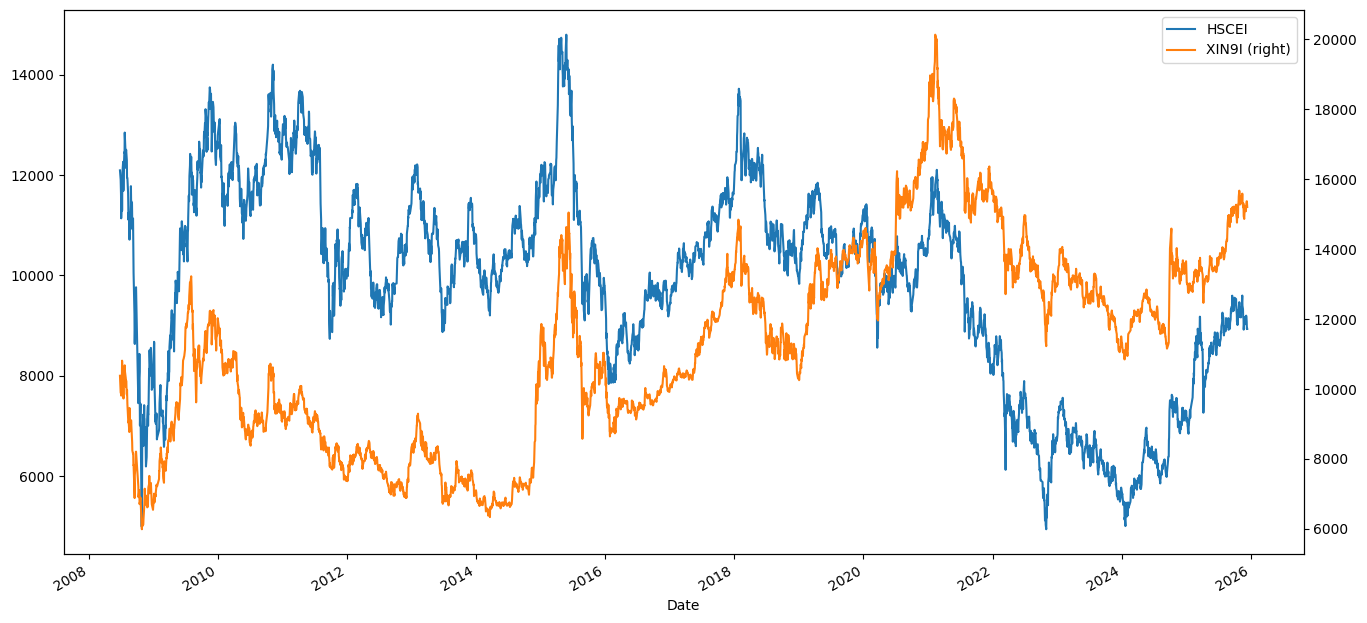

In [5]:
display(price_df.head(10))
price_df = price_df.loc['2008':]
_ = price_df.plot(secondary_y=ticker2)
assert not pd.isna(price_df).any().any()

,HSCEI,XIN9I
Date,,
2007-06-14,7.8171,1
2007-06-18,7.8170,1
2007-06-20,7.8149,1
2007-06-21,7.8122,1
2007-06-25,7.8120,1
2007-06-26,7.8120,1
2007-06-28,7.8164,1
2007-07-04,7.8132,1
2008-06-26,7.8036,1


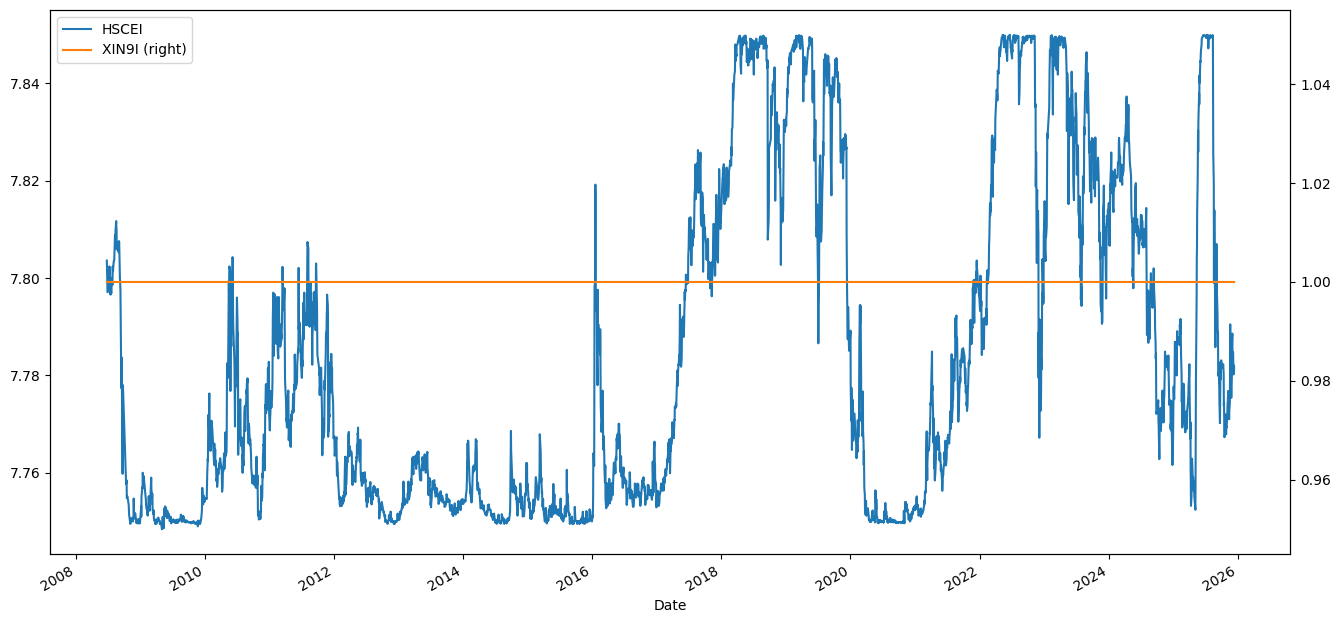

In [6]:
display(fx_df.head(10))
fx_df = fx_df.loc['2008':].ffill()
_ = fx_df.plot(secondary_y=ticker2)
assert not pd.isna(fx_df).any().any()

In [7]:
pts = SignalGeneration(
    n_rolling=20, n_std_enter=2, n_std_exit=1, take_log=True,
    **params,
)
result_df = pts.run(price_df[ticker1], price_df[ticker2])

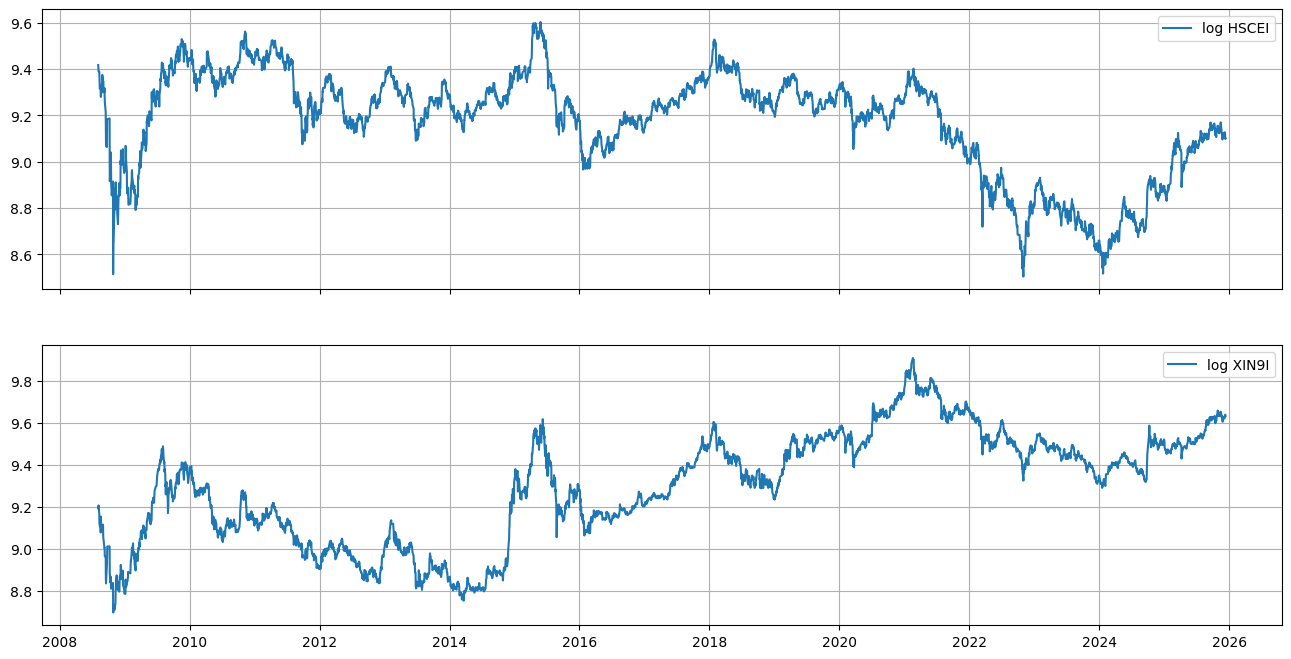

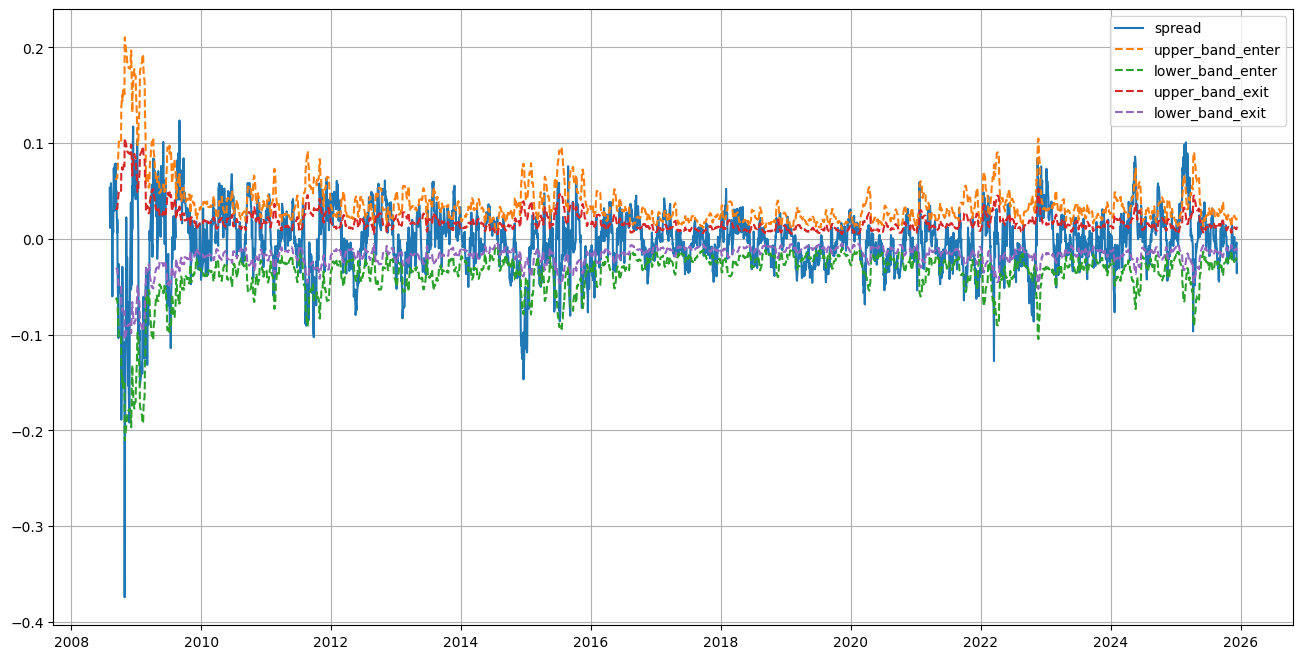

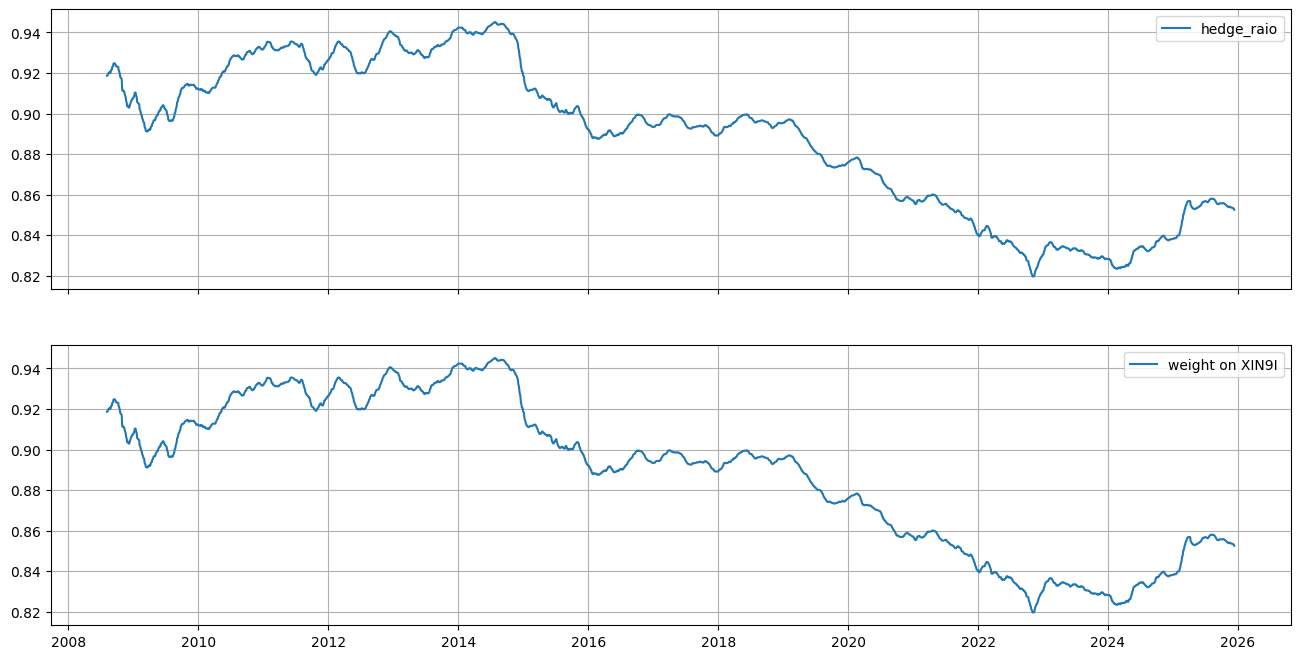

In [8]:
result_df

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(result_df['px_ts1'], label=('log ' + ticker1))
ax[1].plot(result_df['px_ts2'], label=('log ' + ticker2))
ax[0].legend()
ax[0].grid()
ax[1].legend()
ax[1].grid()
plt.show()

plt.plot(result_df['demeaned_spread'], label='spread')
plt.plot(result_df['upper_band_enter'], ls='--', label='upper_band_enter')
plt.plot(result_df['lower_band_enter'], ls='--', label='lower_band_enter')
plt.plot(result_df['upper_band_exit'], ls='--', label='upper_band_exit')
plt.plot(result_df['lower_band_exit'], ls='--', label='lower_band_exit')
plt.legend()
plt.grid()
plt.show()

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(result_df['hedge_ratio'], label='hedge_raio')
ax[1].plot(result_df['hedge_ratio'],
           label='weight on ' + ticker2)
ax[0].legend()
ax[0].grid()
ax[1].legend()
ax[1].grid()

plt.show()


In [9]:
signal_df = result_df[['signal1', 'signal2']]
weight_df = result_df[['weight', 'weight2']]

fees = slippage = 0
fixed_amount = 10_000 # per-asset, per-entry base capital
org_pf = backtest_basket_signal_weight(
    price_df, signal_df, weight_df, fx_df, fixed_amount,
    init_cash=0, fees=fees, slippage=slippage, freq="D",
    cash_sharing=False,
    
)

In [10]:
display(org_pf.stats().rename('stats').to_frame())
print()

org_trd_df = org_pf.trades.records_readable[[
    'Column', 'Size', 'Entry Timestamp', 
    'Exit Timestamp', 'Direction', 
    'Avg Entry Price',  'Avg Exit Price', 
    'Status', 'PnL', 'Return',
]]
org_trd_df.sort_values('Entry Timestamp', inplace=True)
display(org_trd_df)

,stats
Start,2008-08-05 00:00:00
End,2025-12-11 00:00:00
Period,4000 days 00:00:00
Start Value,3_225.6844
End Value,4_766.1460
Total Return [%],79.7295
Benchmark Return [%],13.7187
Max Gross Exposure [%],21_707.3373
Total Fees Paid,0.0000
Max Drawdown [%],30.2945


,Column,Size,Entry Timestamp,Exit Timestamp,Direction,Avg Entry Price,Avg Exit Price,Status,PnL,Return
0,HSCEI,0.0626,2008-09-09,2008-09-16,Short,1_387.9593,1_187.6180,Closed,12.5345,0.1443
176,XIN9I,0.5785,2008-09-09,2008-09-16,Long,8_154.2200,7_025.3200,Closed,-653.0771,-0.1384
177,XIN9I,0.6048,2008-09-23,2008-09-24,Short,7_878.1200,8_203.5400,Closed,-196.8095,-0.0413
1,HSCEI,0.0693,2008-09-23,2008-09-24,Long,1_250.6121,1_253.3187,Closed,0.1876,0.0022
2,HSCEI,0.0867,2008-10-09,2008-10-15,Long,997.5099,1_017.4724,Closed,1.7312,0.0200
...,...,...,...,...,...,...,...,...,...,...
173,HSCEI,0.0733,2025-10-20,2025-10-21,Long,1_188.5977,1_196.9454,Closed,0.6118,0.0070
350,XIN9I,0.3059,2025-11-06,2025-11-11,Short,15_505.5800,15_335.9800,Closed,51.8731,0.0109
174,HSCEI,0.0723,2025-11-06,2025-11-11,Long,1_203.2938,1_217.3190,Closed,1.0138,0.0117
175,HSCEI,0.0756,2025-12-09,2025-12-11,Long,1_148.3289,1_148.0994,Open,-0.0173,-0.0002


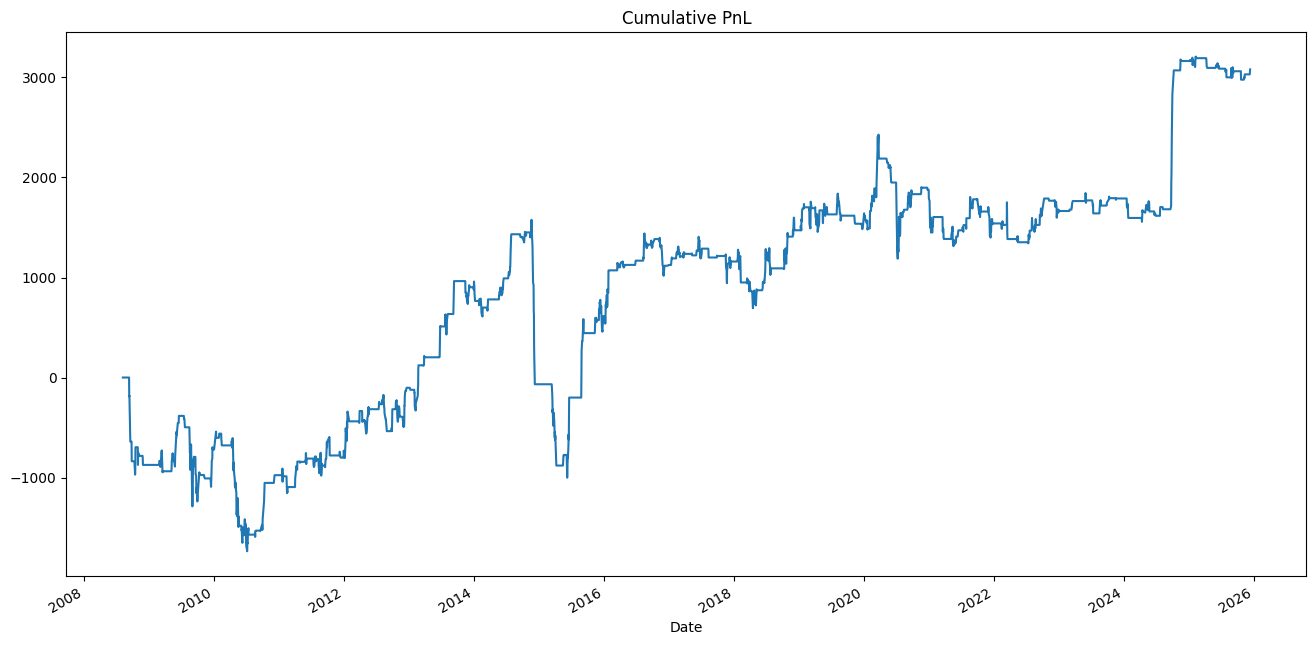

In [11]:
cum_df = org_pf.value().sum(axis=1).diff().fillna(0).cumsum().rename('org') 
_ = cum_df.plot(title='Cumulative PnL')

## Incorporating a regime shift detection filter

To enhance the strategy, we will build a simple regime shift detector using Maximum Mean Discrepancy (MMD) applied to the constructed spread and hedge ratio from the Kalman filter. The idea is to compare the distribution of recent market data (last 1 month) with that of the previous year. If the MMD statistic exceeds the 95th percentile of its historical values over the past year, we classify this as a regime shift.
When a regime shift is detected, we will exit any existing position and suspend trading signals. No new positions will be opened until the regime shift flag clears and a fresh valid signal appears. This approach aims to avoid trading during periods of structural market change.

In [12]:
detector = RegimeShiftDetector(
    ref_window=int(252),
    test_window=20,
    gap=0,
    threshold_quantile=0.95,
)

mmd_df = detector.run(result_df[['demeaned_spread', 'hedge_ratio']])

filter_ts = mmd_df['regime_shift']
filtered_signal_df = pd.DataFrame(index=signal_df.index)
filtered_signal_df[ticker1] = apply_position_filter(signal_df['signal1'].rename(ticker1), filter_ts)
filtered_signal_df[ticker2] = apply_position_filter(signal_df['signal2'].rename(ticker2), filter_ts)


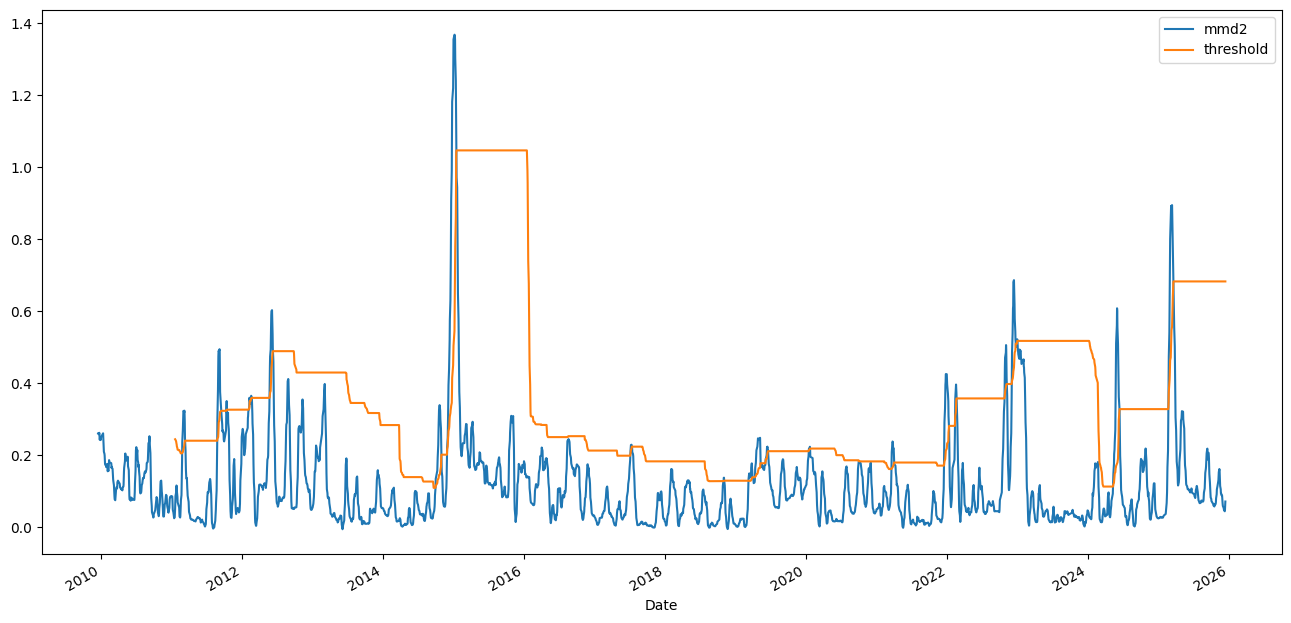

In [13]:
_ = mmd_df[['mmd2', 'threshold']].plot()

In [14]:
filt_pf = backtest_basket_signal_weight(
    price_df, filtered_signal_df, weight_df, fx_df, fixed_amount,
    init_cash=0, fees=fees, slippage=slippage, freq="D",
    cash_sharing=False,  # share one cash pool across assets
)

In [15]:
pf_stats_df = pd.concat([org_pf.stats().rename('original'), filt_pf.stats().rename('filtered')], axis=1)
display(pf_stats_df)

,original,filtered
Start,2008-08-05 00:00:00,2008-08-05 00:00:00
End,2025-12-11 00:00:00,2025-12-11 00:00:00
Period,4000 days 00:00:00,4000 days 00:00:00
Start Value,3_225.6844,3_225.6844
End Value,4_766.1460,5_370.5819
Total Return [%],79.7295,77.7698
Benchmark Return [%],13.7187,13.7187
Max Gross Exposure [%],21_707.3373,57_612.8090
Total Fees Paid,0.0000,0.0000
Max Drawdown [%],30.2945,30.8582


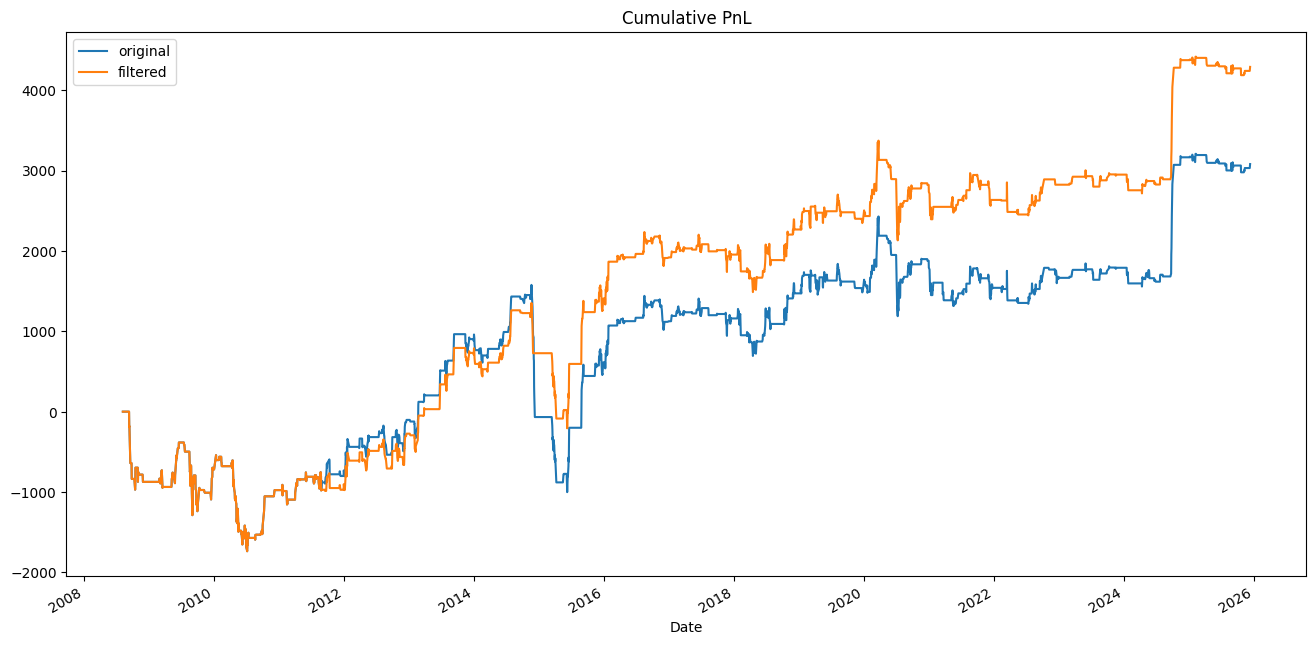

In [16]:
cum_df = pd.concat(
    [org_pf.value().sum(axis=1).diff().fillna(0).cumsum().rename('original'), 
     filt_pf.value().sum(axis=1).diff().fillna(0).cumsum().rename('filtered')], axis=1
)
_  = cum_df.plot(title='Cumulative PnL')